# 4D optimisation with precomputed multi-task initialisation data

This notebook shows how to use data collected in one optimisation task to warm start optimisation in another task.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from boss.bo.bo_main import BOMain
from utils import load_model

optimisation setup:

In [3]:
seed = 221220
num_init = 5
num_iter = 150
acqfn_name = 'elcb'
updatefreq = 10

optimisation tasks:

In [4]:
def f_0(x):
    return unknown_model_0.predict(np.atleast_2d(x))[0]

def f_1(x):
    return unknown_model_1.predict(np.atleast_2d(x))[0]

In [5]:
unknown_model_0 = load_model('../models/model_4D_E0.npz')
unknown_model_1 = load_model('../models/model_4D_E1.npz')

In [6]:
yrange_0 = [0, 20]
yrange_1 = [0, 1]

In [7]:
bounds = [[-50.0, 310.0]] * 4
bounds[1] = [-50.0, 70]  # second dimension has 1/3 period

run optimisation 1:

In [8]:
bo_1 = BOMain(
    f_0, 
    bounds,
    yrange=yrange_0,
    kernel='stdp',
    initpts=num_init,
    iterpts=num_iter,
    minfreq=num_iter,
    updatefreq=updatefreq,
    acqfn_name=acqfn_name,
    seed=seed,
    outfile='boss_4D_E0.out',
    rstfile='boss_4D_E0.rst',
)

In [9]:
%time res_1 = bo_1.run()

CPU times: user 7min 40s, sys: 1min 32s, total: 9min 12s
Wall time: 7min 28s


estimated minimum:

In [10]:
res_1.select('x_glmin', -1)

array([ 56.48716583,  61.96183007, 204.49029388, 179.9732172 ])

use data collected in this optimisation task to warm start optimisation 2:

In [11]:
X = res_1["X"]
Y = res_1["Y"]

In [12]:
num_init = min(num_init, len(X))
X_init = X[:num_init]
Y_init = np.full((num_init, 1), np.nan)

In [13]:
X_init_multi = np.vstack((np.hstack((X_init, np.full((num_init, 1), 0))), np.hstack((X, np.full((len(X), 1), 1)))))
Y_init_multi = np.vstack((Y_init, Y))

initialise optimisation with `num_tasks = 2` and a user function list:

In [14]:
bo_2 = BOMain(
    [f_1], 
    bounds,
    num_tasks=2,
    yrange=yrange_1,
    kernel='stdp',
    iterpts=num_iter,
    minfreq=num_iter,
    updatefreq=updatefreq,
    acqfn_name=acqfn_name,
    seed=seed,
    outfile='warm_start_4D.out',
    rstfile='warm_start_4D.rst',
)

In [15]:
%time res_2 = bo_2.run(X_init=X_init_multi, Y_init=Y_init_multi)

CPU times: user 17min 28s, sys: 3min 40s, total: 21min 9s
Wall time: 17min 54s


estimated minimum:

In [16]:
res_2.select('x_glmin', -1)

array([ 2.35073081e+02,  5.46283108e+01,  6.11747317e+01, -1.59065281e-01,
        0.00000000e+00])

plot:

In [17]:
%time res_2.calc_missing_minima()

CPU times: user 15min 14s, sys: 3min 10s, total: 18min 24s
Wall time: 15min 15s


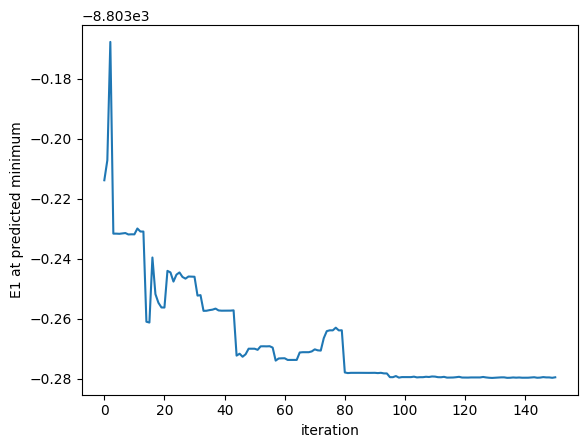

In [18]:
fmin = f_1(np.array(res_2['x_glmin'])[:, :-1])
plt.plot(fmin)
plt.ylabel('E1 at predicted minimum')
plt.xlabel('iteration');